# Практика 3.1: дерево решений с нуля

В этой тетрадке мы:

1. Напомним себе, как работают линейная и логистическая регрессии и какие у них ограничения.
2. Обсудим идею дерева решений как альтернативы линейным моделям.
3. Введём меру нечистоты узла дерева и критерий качества разбиения.
4. Реализуем с нуля простой классификатор на основе дерева решений для бинарной классификации.
5. Посмотрим на границы принятия решений линейной модели и нашего дерева на одном и том же наборе данных.

Во всех примерах ниже будем работать с задачей бинарной классификации: целевая переменная принимает значения $0$ или $1$.

## 1. Линейные модели и их ограничения

На прошлых занятиях мы уже использовали линейную регрессию и логистическую регрессию.

- Линейная регрессия приближает численную целевую переменную формулой вида
$\hat{y} = w^\top x + b$, где $x$ — вектор признаков, $w$ — вектор весов, $b$ — смещение.
- Логистическая регрессия используется для бинарной классификации и моделирует вероятность класса $1$ как
$p(y = 1 \mid x) = \sigma(w^\top x + b)$,
где $\sigma(z) = \dfrac{1}{1 + e^{-z}}$ — сигмоида.

Ключевая особенность этих моделей: разделяющая поверхность между классами задаётся **одной гиперплоскостью** вида
$w^\top x + b = 0$.
В двумерном случае это просто прямая линия на плоскости признаков $(x_1, x_2)$.

Это хорошо работает, когда классы линейно разделимы (или почти линейно разделимы) в исходном пространстве признаков.
Но что делать, если реальные данные устроены сложнее и линейной границей их удобно не отделить?

In [23]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True


In [24]:
# Сгенерируем нелинейно разделимый двумерный датасет
X, y = make_moons(n_samples=400, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print("Accuracy (train):", accuracy_score(y_train, log_reg.predict(X_train)))
print("Accuracy (test): ", accuracy_score(y_test, log_reg.predict(X_test)))

Accuracy (train): 0.8107142857142857
Accuracy (test):  0.8916666666666667


Посмотрим на то, как выглядят наши данные и как логистическая регрессия разделяет классы в пространстве признаков.
Для этого нарисуем:

- точки обучающей выборки (два цвета для двух классов),
- границу принятия решений логистической регрессии.

Граница будет линией уровня $p(y = 1 \mid x) = 0.5$, что эквивалентно условию $w^\top x + b = 0$.

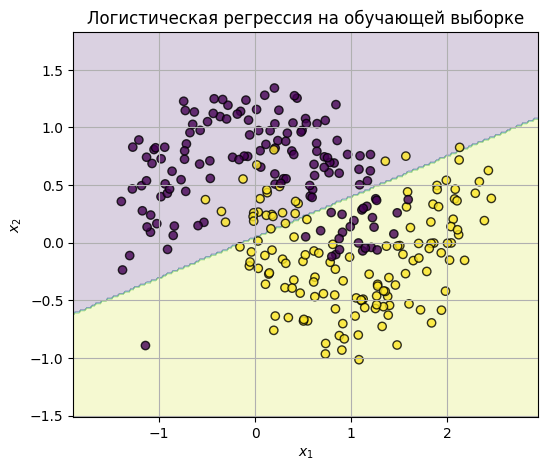

In [25]:
def plot_decision_boundary(model, X, y, h=0.02, title=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.2)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", alpha=0.8)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title is not None:
        ax.set_title(title)
    plt.show()


plot_decision_boundary(log_reg, X_train, y_train, title="Логистическая регрессия на обучающей выборке")

На графике видно, что логистическая регрессия проводит **одну плавную границу**, отделяющую классы.
Для датасета `moons` эта граница не совпадает с "естественной" границей между двумя полумесяцами.

Если мы не хотим вручную добавлять полиномиальные признаки или другие сложные преобразования, нам нужен метод,
который умеет строить **нелинейные** границы принятия решений более гибко.

Одним из таких методов являются деревья решений.

## 2. Интуиция деревьев решений

Идея дерева решений основана на последовательном разбиении пространства признаков на области с более или менее однородными по классу объектами.

В двумерном случае каждое разбиение отвечает на вопрос вида:

- если $x_1 \le t$, идём влево,
- иначе (если $x_1 > t$) идём вправо,

или аналогично по признаку $x_2$.

Геометрически одно такое правило создаёт **вертикальную** или **горизонтальную** линию на плоскости признаков и делит её на две части.
Дальше внутри каждой части можно задать новые вопросы (новые разбиения), получая всё более мелкие прямоугольные области.

Каждая конечная область (лист дерева) будет иметь своё предсказание: например, класс, который чаще всего встречается среди объектов в этой области.

Таким образом, дерево решений строит сложную **ломаную** границу между классами как комбинацию простых правил вида
"если $x_j \le t$, то ...".

### 2.1 Наглядный пример: что значит «если меньше, то идём сюда»

Рассмотрим очень маленький датасет с двумя признаками $x_1$, $x_2$ и бинарной целевой переменной $y$:

| Объект | $x_1$ | $x_2$ | $y$ |
|--------|--------|--------|-----|
| 1      | 2.0    | 1.0    | 0   |
| 2      | 2.5    | 2.0    | 0   |
| 3      | 3.0    | 1.5    | 0   |
| 4      | 4.0    | 3.0    | 1   |
| 5      | 4.5    | 2.5    | 1   |
| 6      | 5.0    | 3.5    | 1   |

Интуитивно видно, что объекты с маленьким $x_1$ относятся к классу $0$, а с большим $x_1$ — к классу $1$.  
Дерево решений будет пытаться записать это правило в виде цепочки простых вопросов «меньше или не меньше порога».

#### Первый вопрос дерева

Представим, что в корне дерева мы выбрали разбиение по признаку $x_1$ с порогом $3.5$:

- если $x_1 \le 3.5$, отправляем объект в **левое поддерево**;
- если $x_1 > 3.5$, отправляем в **правое поддерево**.

Посмотрим, как разделятся наши объекты:

- В левую ветку (условие $x_1 \le 3.5$) попадут объекты 1, 2, 3: у них $y = 0$.
- В правую ветку (условие $x_1 > 3.5$) попадут объекты 4, 5, 6: у них $y = 1$.

То есть одним вопросом вида «если $x_1 \le 3.5$» мы уже идеально разделили классы.  
В этом простом примере дерево останавливается сразу и делает два листа:

- левый лист: предсказываем $y = 0$ для всех объектов с $x_1 \le 3.5$;
- правый лист: предсказываем $y = 1$ для всех объектов с $x_1 > 3.5$.

#### Пример с дополнительными вопросами

Теперь усложним ситуацию. Пусть у нас есть ещё один объект:

| Объект | $x_1$ | $x_2$ | $y$ |
|--------|--------|--------|-----|
| 7      | 4.2    | 0.8    | 0   |

У него $x_1 = 4.2$, то есть по первому вопросу «если $x_1 \le 3.5$» он пойдёт в правую ветку (ту, где у нас в основном класс $1$), но его настоящий класс $y = 0$.  
Значит, внутри правой ветки дерево может задать **ещё один вопрос**, например по признаку $x_2$:

- если $x_2 \le 1.5$, считаем, что это всё ещё класс $0$;
- если $x_2 > 1.5$, считаем, что это уже класс $1$.

Тогда путь для рекомендации класса выглядит так:

1. Сначала проверяем $x_1$:
   - если $x_1 \le 3.5$, предсказываем $y = 0$;
   - если $x_1 > 3.5$, переходим ко второму вопросу.
2. Во второй ветке проверяем $x_2$:
   - если $x_2 \le 1.5$, предсказываем $y = 0$;
   - если $x_2 > 1.5$, предсказываем $y = 1$.

Можно думать об этом как о последовательности вложенных условий:

- «Сначала спросили про $x_1$, если он маленький — сразу решили, если большой — спросили ещё и про $x_2$.»

#### Связь с идеей «кучи `if`-ов»

С точки зрения программной логики дерево решений — это просто много вложенных проверок вида:

- если признак $x_j$ **меньше или равен** порогу $t$, идём по одной ветке;
- иначе (признак **больше** $t$) идём по другой ветке.

На каждом шаге мы постепенно уточняем, в какой области пространства признаков находится объект, и в конечном счёте попадаем в лист, где уже зашито «окончательное» решение (предсказание класса).

Другими словами, дерево решений приближает сложную границу между классами с помощью **набора простых правил вида**:

- «если $x_1$ меньше такого-то числа и $x_2$ больше такого-то числа, то класс $1$»,
- «если $x_1$ больше порога, но $x_2$ меньше порога, то класс $0$»,

и так далее.


## 3. Нечистота узла и критерий качества разбиения

Чтобы построить дерево, нам нужно уметь отвечать на вопрос:
"Какое разбиение выборки на два подмножества по признаку $x_j$ и порогу $t$ является лучшим?".

Интуитивно "хорошее" разбиение делает подвыборки **более однородными** по классам.
Чтобы формализовать эту идею, вводится понятие *нечистоты узла*.

Одна из популярных мер нечистоты для бинарной классификации — индекс Джини. Пусть в узле содержится $n$ объектов,
доля класса $1$ равна $p$, а доля класса $0$ равна $1 - p$. Тогда нечистота узла равна

$G = 1 - p^2 - (1 - p)^2.$

- Если в узле все объекты принадлежат одному классу, то $p$ равно $0$ или $1$, и нечистота $G = 0$ (узел чистый).
- Если в узле классы смешаны примерно поровну, $p \approx 0.5$, и нечистота $G$ максимальна.

Пусть мы делим исходный узел на левое и правое поддерево по правилу $x_j \le t$.
Обозначим через $n_L$ и $n_R$ число объектов в левом и правом узлах, а через $G_L$ и $G_R$ — их нечистоты.
Тогда **средневзвешенная нечистота после разбиения** будет равна

$G_{\text{split}} = \dfrac{n_L}{n} G_L + \dfrac{n_R}{n} G_R,$

где $n = n_L + n_R$ — общее число объектов в исходном узле.

При построении дерева мы хотим найти такое разбиение, для которого $G_{\text{split}}$ минимально, то есть поддеревья максимально однородны по классам.

In [26]:
def gini_impurity(y) -> float:
    """Вычисление индекса Джини для вектора меток y (0/1)."""
    if len(y) == 0:
        return 0.0
    p = np.mean(y)
    return 1.0 - p ** 2 - (1.0 - p) ** 2


# Пример: проверим, как меняется G при разных долях класса 1
ps = np.linspace(0, 1, 11)
g_values = [1.0 - p ** 2 - (1.0 - p) ** 2 for p in ps]

for p, g in zip(ps, g_values):
    print(f"p = {p:.1f}, G = {g:.3f}")

p = 0.0, G = 0.000
p = 0.1, G = 0.180
p = 0.2, G = 0.320
p = 0.3, G = 0.420
p = 0.4, G = 0.480
p = 0.5, G = 0.500
p = 0.6, G = 0.480
p = 0.7, G = 0.420
p = 0.8, G = 0.320
p = 0.9, G = 0.180
p = 1.0, G = 0.000


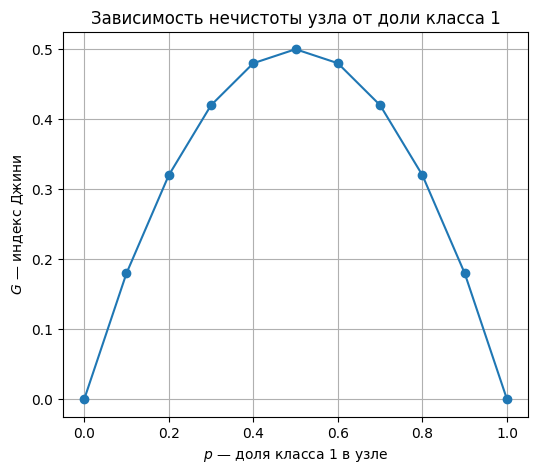

In [27]:
fig, ax = plt.subplots()
ax.plot(ps, g_values, marker="o")
ax.set_xlabel("$p$ — доля класса 1 в узле")
ax.set_ylabel("$G$ — индекс Джини")
ax.set_title("Зависимость нечистоты узла от доли класса 1")
plt.show()

На графике видно, что индекс Джини равен $0$, когда $p = 0$ или $p = 1$ (узел полностью однороден) и достигает максимума при $p = 0.5$ (классы смешаны поровну).

Теперь нам осталось реализовать алгоритм, который перебирает возможные разбиения и выбирает то, которое минимизирует $G_{\text{split}}$.

## 4. Реализация простого дерева решений с нуля

Сделаем несколько упрощающих предположений, чтобы сосредоточиться на сути алгоритма:

1. Задача — бинарная классификация с метками $0$ и $1$.
2. Все признаки числовые, без пропусков.
3. Внутри узла мы рассматриваем разбиения только вида $x_j \le t$ для каждого признака $x_j$ и порога $t$.
4. Останавливаем рост дерева, если выполнено хотя бы одно из условий:
   - достигнута максимальная глубина $\text{max\_depth}$,
   - число объектов в узле меньше $\text{min\_samples\_split}$,
   - все объекты в узле принадлежат одному классу.

В каждом листе будем хранить предсказание класса. Обозначим через $n_1$ и $n_0$ количество объектов классов $1$ и $0$ в листе.
Тогда предсказанием будет класс с большинством голосов:

$\hat{y} = \begin{cases}
1, & \text{если } n_1 \ge n_0, \\
0, & \text{иначе}.
\end{cases}$

Сначала напишем вспомогательные функции для поиска лучшего разбиения в одном узле, а затем соберём их в класс `SimpleDecisionTree`.

In [28]:
def best_split(X, y) -> (Optional[int], Optional[float], float, Optional[int], Optional[int]):
    """Поиск лучшего разбиения по всем признакам.

    Возвращает кортеж (best_feature, best_threshold, best_impurity, best_left_idx, best_right_idx).
    Если подходящего разбиения нет, возвращает (None, None, текущая_нечистота, None, None).
    """
    n_samples, n_features = X.shape
    if n_samples <= 1:
        return None, None, gini_impurity(y), None, None

    current_impurity = gini_impurity(y)
    best_impurity = current_impurity
    best_feature = None
    best_threshold = None
    best_left_idx = None
    best_right_idx = None

    for feature in range(n_features):
        X_column = X[:, feature]
        # Уникальные значения признака в отсортированном порядке
        thresholds = np.unique(X_column)

        for threshold in thresholds:
            left_mask = X_column <= threshold
            right_mask = ~left_mask

            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            y_left = y[left_mask]
            y_right = y[right_mask]

            n_left = len(y_left)
            n_right = len(y_right)
            impurity_left = gini_impurity(y_left)
            impurity_right = gini_impurity(y_right)

            impurity_split = (n_left * impurity_left + n_right * impurity_right) / (n_left + n_right)

            if impurity_split < best_impurity:
                best_impurity = impurity_split
                best_feature = feature
                best_threshold = threshold
                best_left_idx = np.where(left_mask)[0]
                best_right_idx = np.where(right_mask)[0]

    return best_feature, best_threshold, best_impurity, best_left_idx, best_right_idx

In [29]:
class Node:
    def __init__(
            self,
            feature: Optional[int] = None,
            threshold: Optional[float] = None,
            left: Optional['Node'] = None, right: Optional['Node'] = None,
            value: Optional[int] = None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left: Optional[Node] = left
        self.right: Optional[Node] = right
        self.value: Optional[int] = value  # предсказанный класс в листе

    @property
    def is_leaf(self):
        return self.value is not None


class SimpleDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root: Optional[Node] = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth: int) -> Node:
        num_samples = len(y)
        num_pos = np.sum(y == 1)
        num_neg = np.sum(y == 0)

        # Текущее предсказание в узле — класс большинства
        if num_pos >= num_neg:
            leaf_value = 1
        else:
            leaf_value = 0

        # Условия остановки роста дерева
        if (
                depth >= self.max_depth
                or num_samples < self.min_samples_split
                or num_pos == 0
                or num_neg == 0
        ):
            return Node(value=leaf_value)

        feature, threshold, impurity, left_idx, right_idx = best_split(X, y)

        # Если не удалось найти разбиение лучше текущего состояния — делаем лист
        if feature is None or left_idx is None or right_idx is None:
            return Node(value=leaf_value)

        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_child, right=right_child)

    def _predict_one(self, x, node: Node) -> int:
        if node.is_leaf:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_one(x, self.root) for x in X])

Теперь обучим наше дерево на том же датасете `moons` и посмотрим на качество классификации и границу решений.

In [30]:
tree = SimpleDecisionTree(max_depth=5, min_samples_split=5)
tree.fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

print("Accuracy (train):", accuracy_score(y_train, y_pred_train))
print("Accuracy (test): ", accuracy_score(y_test, y_pred_test))

print("\nОтчёт по качеству на тесте:\n")
print(classification_report(y_test, y_pred_test))

Accuracy (train): 0.9678571428571429
Accuracy (test):  0.9166666666666666

Отчёт по качеству на тесте:

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        60
           1       0.93      0.90      0.92        60

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120



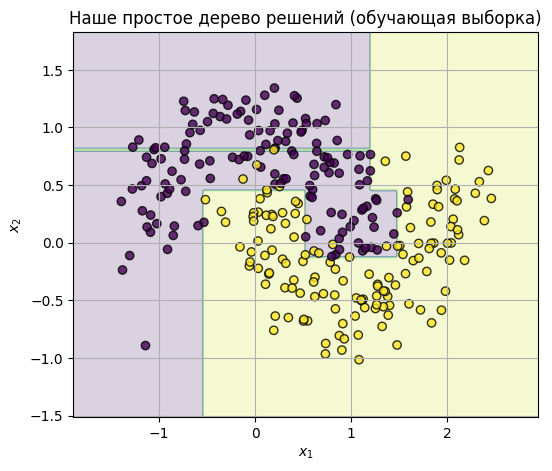

In [31]:
plot_decision_boundary(tree, X_train, y_train, title="Наше простое дерево решений (обучающая выборка)")

Можно заметить, что граница, построенная деревом решений, имеет характерную "ступенчатую" форму.
Это отражает то, как дерево делит пространство признаков с помощью последовательности правил вида
"если $x_j \le t$, идём влево, иначе идём вправо".

В отличие от логистической регрессии, которая использует одну глобальную гиперплоскость,
дерево может подстраиваться под локальную структуру данных и строить сложные нелинейные границы.

Попробуем посмотреть, как изменится граница решений и качество модели при разной максимальной глубине дерева.

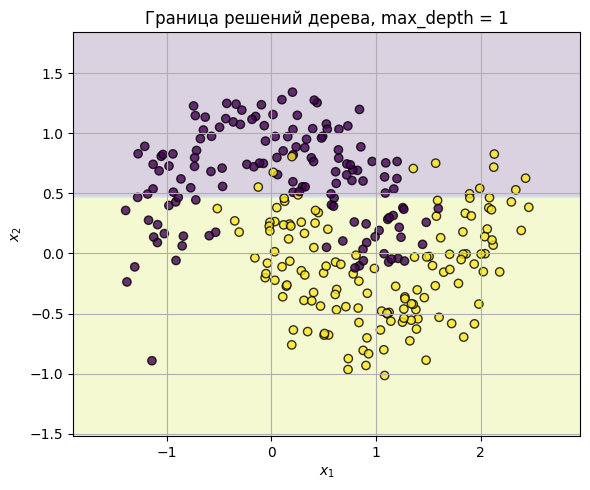

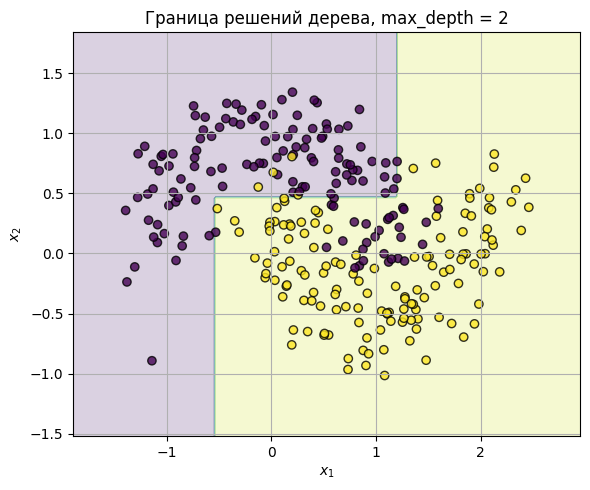

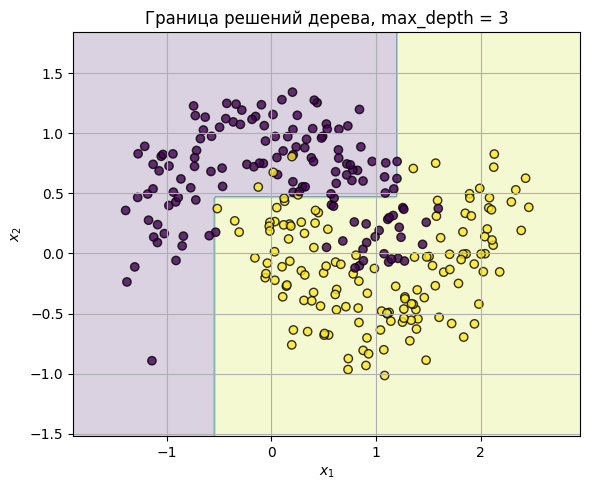

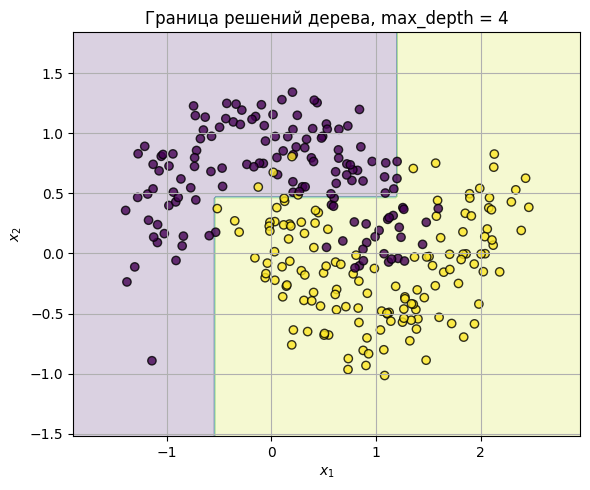

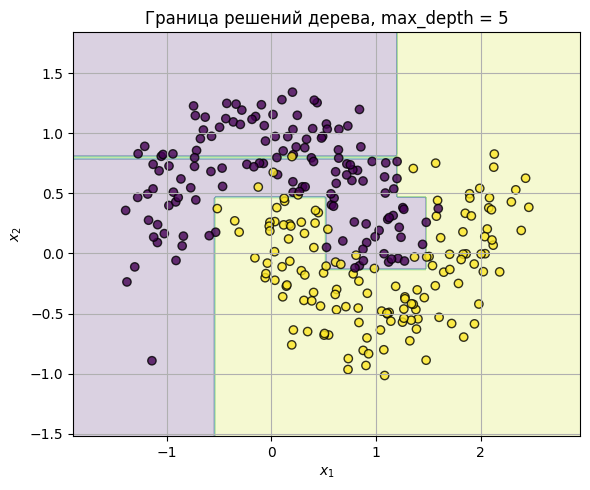

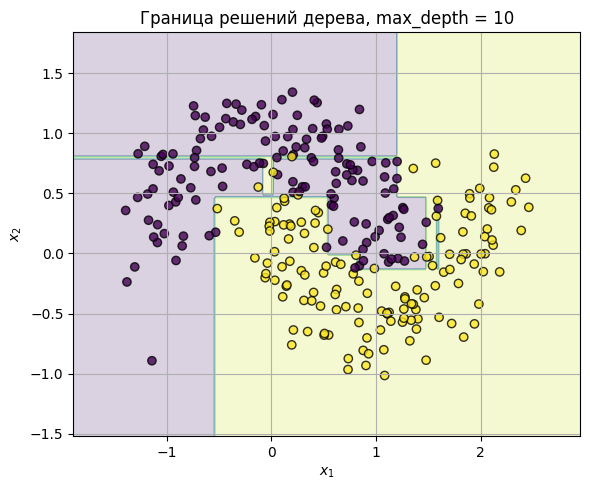

In [33]:
depths = [1, 2, 3, 4, 5, 10]

for d in depths:
    model = SimpleDecisionTree(max_depth=d, min_samples_split=5)
    model.fit(X_train, y_train)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.02),
        np.arange(y_min, y_max, 0.02)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="k", alpha=0.8)
    ax.set_title(f"Граница решений дерева, max_depth = {d}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    plt.tight_layout()
    plt.show()


При маленькой глубине ($\text{max\_depth} = 1$ или $2$) дерево слишком грубо делит пространство и не успевает подстроиться под структуру данных — это пример **недообучения**.

При увеличении глубины модель становится гибче и точнее описывает сложные зависимости.
Однако слишком глубокие деревья могут переобучаться: практически идеально запоминают обучающую выборку, но начинают хуже обобщать на новые данные.

Мы уже видели похожее поведение для полиномиальной регрессии, когда степень полинома увеличивалась.
В случае деревьев глубина играет роль гиперпараметра, который контролирует баланс между сложностью модели и обобщающей способностью.

## 5. Итоги и связь с дальнейшими темами

В этой тетрадке мы:

1. Вспомнили, что линейные модели (линейная и логистическая регрессия) строят одну глобальную гиперплоскость $w^\top x + b = 0$ для разделения классов.
2. Увидели на примере датасета `moons`, что такая граница может быть недостаточно гибкой для сложных данных.
3. Обсудили идею дерева решений как последовательности простых правил вида $x_j \le t$, которая делит пространство признаков на прямоугольные области.
4. Ввели меру нечистоты узла — индекс Джини $G = 1 - p^2 - (1 - p)^2$ и критерий качества разбиения $G_{\text{split}}$.
5. Реализовали с нуля простой классификатор на основе дерева решений и увидели, как меняется его поведение при разной максимальной глубине.

В следующих частях мы еще немного улучшим текущую версию самописного дерева и затем уже перейдём к промышленным реализациям деревьев решений в `sklearn`, обсудим дополнительные гиперпараметры,
а также познакомимся с ансамблевыми методами на основе деревьев: случайным лесом и градиентным бустингом.
Они позволяют существенно повысить качество по сравнению с одним деревом и являются стандартными инструментами для табличных данных.